# 导包

In [17]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 指定使用 GPU 1
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

1530

# 数据处理

In [ ]:
depth = depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed

data_input = data_surface

data_st = data_st_processed[0:132,:,:,:]
data_underwater = np.load(r'./with_noise/rate95_5/layer1_pred_data.npy')
print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[:,:,:,1:2] #(132,  100，160， 1)
print(out_data_y.shape)

(132, 108, 168, 5) (132, 100, 160, 20)
(132, 100, 160, 1)


In [19]:
print('----------------for layer2_ST--------------------')

time_size, lat_size, lon_size, channel1 = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 

channel2 =  data_underwater.shape[3]
pro_data = np.zeros((time_size, lat_size , lon_size, channel2)) #(132, 208, 208, 6)

for t in range(time_size):
    # 2

    pro1 = np.concatenate((np.zeros((4 , out_lon_size, channel2)),data_underwater[t,:,:,:],np.zeros((4 , out_lon_size, channel2)))) #9*9
    # pro1 = np.concatenate((np.zeros((5 , out_lon_size, channel)),data_surface[t,:,:,:],np.zeros((5 , out_lon_size, channel)))) #

    pro1 = np.transpose(pro1,(1,0,2))
    # print(pro1.shape)

    pro2 = np.concatenate((np.zeros((4 , out_lat_size+box_size-1, channel2)),pro1[:,:,:],np.zeros((4 , out_lat_size+box_size-1, channel2)))) #9*9
    # pro2 = np.concatenate((np.zeros((5 , out_lon_size+box_size-1, channel)),pro1[:,:,:],np.zeros((5 , out_lon_size+box_size-1, channel)))) #

    pro2 = np.transpose(pro2,(1,0,2))
    # print(pro2.shape) 
    pro_data[t,:,:,:] = pro2

pro_data_out = np.concatenate((data_input, pro_data), axis=-1)
channel = channel1 + channel2
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data_out[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []   

----------------for layer2_ST--------------------
(132, 100, 160, 9, 9, 6)


In [20]:
# 修改变量形状
out_data_reshape = out_data.reshape((132,-1,9,9,channel))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)
    

(132, 16000, 9, 9, 6)
(132, 16000, 9, 9, 6)
(16000, 81)


In [21]:
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,1)
print('out_data_y_reshape:',out_data_y_reshape.shape)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)
    

out_data_reshape: (16000, 132, 9, 9, 6)
out_data_y_reshape: (100, 160, 132, 1)
out_data_y_reshape: (16000, 132, 1)


In [22]:
print(nan_mask2)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [23]:
nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]


In [24]:
out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

In [25]:
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)

# 最后十二个月的数据作为test
test_num = 120
x_train = out_data_reshape[:test_num]
y_train = out_data_y_reshape[:test_num]

x_test = out_data_reshape[test_num:]
y_test = out_data_y_reshape[test_num:]

# 将前两个维度进行合并  时间*(lat*lon)
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

out_data_reshape: (132, 14783, 9, 9, 6)
out_data_y_reshape: (132, 14783, 1)


In [26]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape


In [27]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[3])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[3]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[3]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[1])) 

In [28]:
x_train = np.reshape(x_train,(-1,9,9,channel))
x_test = np.reshape(x_test,(-1,9,9,channel))
x_val = np.reshape(x_val,(-1,9,9,channel))
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))

# 模型训练

# 无注意力机制

In [29]:
# 使用自定义注意力层
def create_model(neurons1, neurons2):
    # 第一部分输入
    model_input = Input(shape=x_train.shape[1:3] + (5,))
    x = Conv2D(filters=neurons1, kernel_size=(3, 3), strides=1)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(filters=neurons2, kernel_size=(3, 3), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    # x = Dense(units=16, activation='relu')(x)

    # 第二部分输入
    model_input2 = Input(shape=x_train.shape[1:3] + (1,))


    # 第二部分卷积网络
    x1 = Conv2D(filters=32, kernel_size=(3, 3), strides=1)(model_input2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv2D(filters=64, kernel_size=(3, 3), strides=1)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Flatten()(x1)
    x1 = Dense(units=8, activation='relu')(x1)
    # x1 = Dense(units=16, activation='relu')(x1)
    
    # 正确写法（方法1）
    concatenated = Concatenate(axis=-1)([
        Lambda(lambda x: 0.95 * x)(x),
        Lambda(lambda x: 0.05 * x)(x1)
    ])

    # 后续层
    # concatenated = Dense(32, activation='relu')(concatenated)
    concatenated = Dense(units=32, activation='relu')(concatenated)
    concatenated = Dense(units=16, activation='relu')(concatenated)
    

    # # 输出层
    out = Dense(units=1)(concatenated)
    
    # out = Dense(units=1)(x1)
    

    # 创建模型
    model = Model(inputs=[model_input, model_input2], outputs=out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 创建模型
model = create_model(128, 256)

# 回调函数
checkpoint_path = 'layer2_no/CNN_model_layer2_st_no.keras'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


# 训练模型
num_epochs = 200
batch_size = 2048
# history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:14]], y_train,
                    # validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:14]], y_val),
                    # epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=[keras_callbacks, OutputCallback()])
                    
history = model.fit([x_train[:,:,:,0:5], x_train[:,:,:,5:6]], y_train,
                    validation_data=([x_val[:,:,:,0:5], x_val[:,:,:,5:6]], y_val),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

Epoch 1/200


2025-04-20 18:43:48.271588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 40 bytes spill stores, 40 bytes spill loads

2025-04-20 18:44:06.412807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 196 bytes spill stores, 184 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 196 bytes spill stores, 184 bytes spill loads



607/607 - 39s - 64ms/step - loss: 0.0207 - val_loss: 0.0105
Epoch 2/200
607/607 - 16s - 26ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 3/200
607/607 - 18s - 29ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/200
607/607 - 16s - 26ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 5/200
607/607 - 18s - 30ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 6/200
607/607 - 16s - 26ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 7/200
607/607 - 16s - 26ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 8/200
607/607 - 19s - 31ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 9/200
607/607 - 16s - 26ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 10/200
607/607 - 19s - 31ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 11/200
607/607 - 16s - 26ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 12/200
607/607 - 18s - 29ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 13/200
607/607 - 16s - 26ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 14/200
607/607 - 16s - 26ms/step - loss: 0.0045 - val_loss: 0.0036

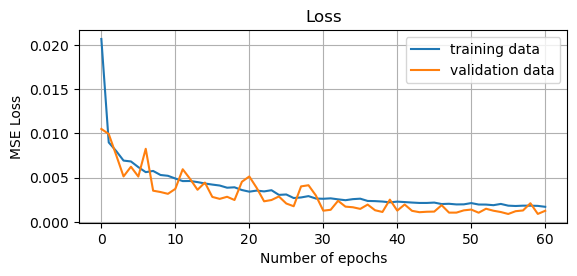

5544/5544 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step
Test RMSE: 0.075
acc: 99.7132
R² score: 0.9942212700843811


In [31]:
look_loss(history)
best_model1 = tf.keras.models.load_model('layer2_no/CNN_model_layer2_st_no.keras', 
    safe_mode=False)
all_estimate(best_model1,[x_test[:,:,:,0:5], x_test[:,:,:,5:6]], y_test)#x_test[:,:,:,0:5], x_test[:,:,:,5:6], y_test

In [ ]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer2_no/CNN_model_layer2_st_no.keras', 
    safe_mode=False)
testPred = best_model.predict([x_test[:,:,:,0:5], x_test[:,:,:,5:6]])
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer2_st = scaler_l.inverse_transform(result)
y_test_layer2_unscaled = scaler_l.inverse_transform(y_test)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step


In [34]:
r2 = r2_score(y_test_layer2_unscaled[:,0],predict_layer2_st[:,0])
print('layer2 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer2_unscaled[:,0]-predict_layer2_st[:,0])))
print('layer2 Test mae: %.3f' % mae)

layer2 R² score: 0.9942212700843811
layer2 Test mae: 0.173


Results written to results.txt
[[27.78116608 27.84358788 27.89030075 ... 27.14347076 27.17015457
  27.22368431]
 [27.76262665 27.81351662 27.85671616 ... 26.98899078 27.0898838
  27.18110085]
 [27.79673004 27.77219391 27.8217659  ... 27.01371956 27.01989937
  27.10638428]
 ...
 [12.76667404 12.6396637  12.26839161 ... 14.0889349  14.13824654
  14.08202744]
 [12.89050007 12.57846928 12.52942181 ... 13.42437744 13.46825123
  13.37309647]
 [        nan         nan 11.699893   ... 12.1374464  12.01918888
  11.75015736]]


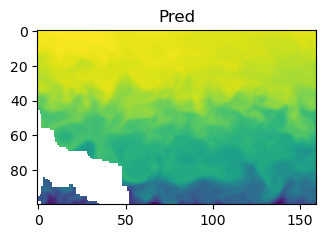

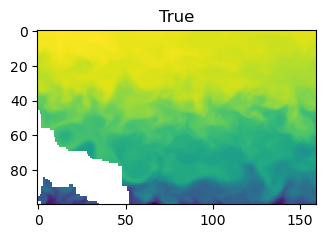

[[27.70992088 27.73189545 27.75020599 ... 27.10785294 27.12103653
  27.14593887]
 [27.69234276 27.71578217 27.7370224  ... 27.05877876 27.07928658
  27.1100502 ]
 [27.70113182 27.72457123 27.74434662 ... 27.00970459 27.02947998
  27.06830025]
 ...
 [12.85302258 12.92773247 12.60838604 ... 14.20438194 14.24832916
  14.23514557]
 [13.27344608 12.58787823 12.82665443 ... 13.51808167 13.60817337
  13.54884529]
 [        nan         nan 11.80416298 ... 12.30661869 12.24289703
  12.08835125]]


6516

In [35]:
predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 )) 
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer2_st
true_data[non_nan_mask] = y_test_layer2_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer2_no/results.txt", "w") as file:
    file.write(f"layer2 R² score: {r2}\n")
    file.write(f"layer2 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer2_no/predict_data.npy',predict_data)
np.save(r'./layer2_no/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()